## TLC Data Lab

TLC: Taxi and Limousine commission provides open data for yellow taxis, FHV, shared FHV and green taxis for NYC. Data includes information about each trip containing pick up and drop off times, fare information, number of passengers, miles traveled etc.

### Objectives

- Cleaning the data - filtering out the outliers and trips with unreasonable parameters
- Explore spatial and temporal data distribution of the number of trips, distances etc, fares and the travel speed.
- Practice spatial mapping with geopandas

### Skills

- Data cleaning and sanity checks
- convert non-spatial data to spatial with geopandas
- visualizing data on the maps

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import urllib
import sys
from matplotlib import pyplot as plt
%matplotlib inline

Downloading TLC yellow taxi data January 2019

In [2]:
#upload the data; the file is big, so takes some time, under a minute
data = pd.read_csv('/home/jovyan/shared/Data/yellow_trips_19.csv', parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
data.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,fare_amount
0,0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,151,239,7.0
1,1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,239,246,14.0
2,2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,236,236,4.5
3,3,2,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,193,193,3.5
4,4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,193,193,52.0


'PULocationID' and 'DOLocationID' are the pick up and drop off taxi zones. 'fare_amount' is the trip cost, 'trip_distance' is the distance of the trip in miles. We will analyze the trips by travel duration, cost, distances and speed.

In [3]:
data.dtypes #get the column names with types

Unnamed: 0                        int64
VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
PULocationID                      int64
DOLocationID                      int64
fare_amount                     float64
dtype: object

### creating a column for travel time in minutes

In [4]:
data['trip_duration'] = (data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime'])
data['trip_duration'] = data['trip_duration'].dt.total_seconds()/60
data.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,fare_amount,trip_duration
0,0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,151,239,7.0,6.666667
1,1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,239,246,14.0,19.200000
2,2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,236,236,4.5,4.166667
3,3,2,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,193,193,3.5,3.333333
4,4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,193,193,52.0,1.600000


### creating column for average travel speed (mph)

In [5]:
data['speed'] = data['trip_distance']/(data['trip_duration']/60)

### check some basic statistics

In [6]:
data[['trip_distance', 'trip_duration', 'fare_amount', 'speed']].describe()

,trip_distance,trip_duration,fare_amount,speed
count,7.667792e+06,7.667792e+06,7.667792e+06,7.661824e+06
mean,2.801084e+00,1.648122e+01,1.240941e+01,inf
std,3.737529e+00,8.181505e+01,2.620721e+02,NaN
min,0.000000e+00,-8.428050e+04,-3.620000e+02,-4.016583e-02
25%,9.000000e-01,6.100000e+00,6.000000e+00,7.586553e+00
50%,1.530000e+00,1.015000e+01,8.500000e+00,1.008621e+01
75%,2.800000e+00,1.656667e+01,1.350000e+01,1.373333e+01
max,8.318000e+02,4.364802e+04,6.232599e+05,inf


The total number of records is approximately 7.7M. 

But we can notice all kinds of issues including zero trip distances, negative durations and fare amounts as well fares, extra high distances, durations and fares as well as resulting negative, NaN and infinite speeds (due to travel time 0 or both travel time and distance 0).

So some data cleaning is required

Removing the trips with duration 0

In [7]:
sum(data.trip_duration <= 0) #number of trips with non-positive duration

6294

In [8]:
sum(data.fare_amount <= 0) #number of trips with non-positive fare amount

9557

In [9]:
sum(data.trip_distance <= 0) #number of trips with non-positive distance

54770

In [10]:
validind = (data.trip_duration > 0) & (data.trip_distance > 0) & (data.fare_amount > 0) #index of valid trips

In [11]:
sum(~validind) #total number of invalid trips

61680

In [12]:
#filter the data - positive duration, distance, fare amount
data = data[validind]

In [13]:
#recompute the statistics
data[['trip_distance', 'trip_duration', 'fare_amount', 'speed']].describe()

,trip_distance,trip_duration,fare_amount,speed
count,7.606112e+06,7.606112e+06,7.606112e+06,7.606112e+06
mean,2.821921e+00,1.659043e+01,1.226454e+01,1.322520e+01
std,3.741116e+00,7.536785e+01,2.262769e+02,1.375292e+02
min,1.000000e-02,1.666667e-02,1.000000e-02,4.190188e-04
25%,9.200000e-01,6.166667e+00,6.000000e+00,7.636364e+00
50%,1.550000e+00,1.021667e+01,9.000000e+00,1.012048e+01
75%,2.820000e+00,1.661667e+01,1.350000e+01,1.376771e+01
max,8.318000e+02,4.364802e+04,6.232599e+05,7.344000e+04


In [14]:
#now the values are formally valid, but we still see unreasonably small and large values for either quantity

### check the distributions for these variables

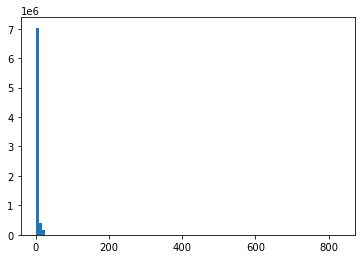

In [15]:
#uniform scale histogram for trip distance does not tell much
n_bins = 100
plt.hist(data.trip_distance, bins=n_bins);

log-scale histogram

In [16]:
def plot_loghist(x, bins): #introduce a function for plotting a log-scale histogram
  #it ensures log-scale binning and label on the original scale
    logbins = np.logspace(np.log10(x.min()),np.log10(x.max()),bins)
    plt.hist(x, bins=logbins)
    plt.xscale('log')

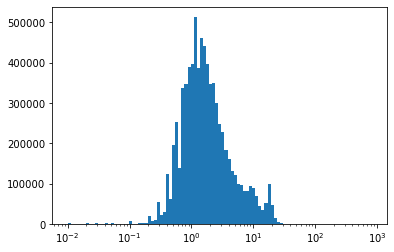

In [17]:
plot_loghist(data.trip_distance, 100)

most of the trips are within 0.2 and 20 miles

In [18]:
#use box plot for more detail on the quantiles

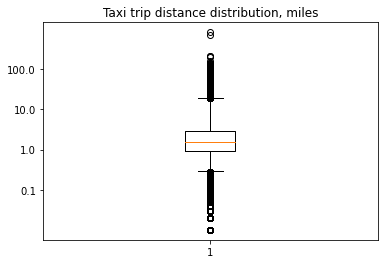

In [19]:
ax = plt.subplot(1, 1, 1)
ax.boxplot(np.log10(data.trip_distance), whis=[1, 99]) #box plot of the log trip_distance with 1 and 99 percentiles and the outliers beyond them
ax.set_yticks(np.arange(-1, 3))
ax.set_yticklabels(10.0**np.arange(-1, 3, 1))
ax.set_title('Taxi trip distance distribution, miles')
plt.show()

In [20]:
#Exact 1% percetile
data.trip_distance.quantile(0.01)

0.29

In [21]:
#Exact 99% percetile
data.trip_distance.quantile(0.99)

18.9

So while 98% of the trips are within around 0.3-19 miles, some are too short (<0.3 mile) others too long; perpahs trips over 20miles are still possible but those >100miles look unrealistic for NYC (those would be 2.5times the driving distance between Staten Island, northern Bronx or EWR (included in the analysis) and JFK or Far Rockaways, which is around 40miles).

check number of trips with high distance (100 miles)

In [22]:
len(data[data.trip_distance > 100])

30

distribution for speed

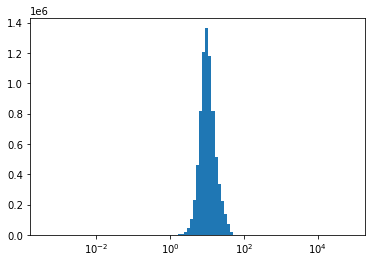

In [23]:
plot_loghist(data.speed, 100)

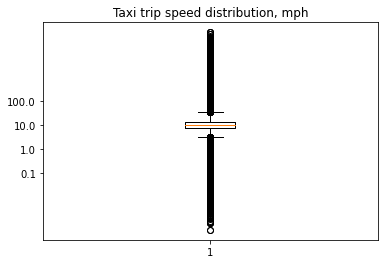

In [24]:
ax = plt.subplot(1, 1, 1)
ax.boxplot(np.log10(data.speed), whis=[1, 99]) #box plot of the log speed with 1 and 99 percentiles and the outliers beyond them
ax.set_yticks(np.arange(-1, 3))
ax.set_yticklabels(10.0**np.arange(-1, 3, 1))
ax.set_title('Taxi trip speed distribution, mph')
plt.show()

In [25]:
data.speed.quantile(0.01)

3.126550868486352

In [26]:
data.speed.quantile(0.99)

36.02623276967928

We can use 1% percentile for lower oulier filtering (all those trips are slower than relaxed walk on average). For upper outliers take the max speed limit of 65mph and add 15mph on top as the vehicle might be speeding, but perhaps not all the time.

In [27]:
len(data[data.speed > 80]) #number of trips with unreasonably high speed

5938

trip duration distribution

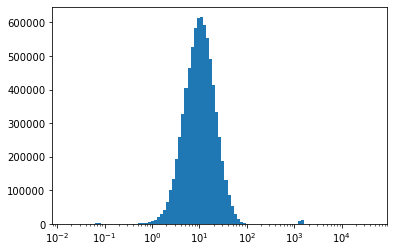

In [28]:
plot_loghist(data.trip_duration, 100)

we see some trips with extreme duration - less than 1minute or more than 1000 minutes. Set the range as 1-100 minutes max

In [29]:
len(data[data.trip_duration > 100]) #number of ourliers

21538

In [30]:
len(data[data.trip_duration < 1])

28955

fare amount distributions

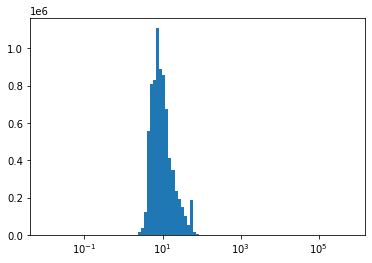

In [31]:
plot_loghist(data.fare_amount, 100)

In [32]:
data.fare_amount.quantile(0.99)

52.0

In [33]:
#The top 1% of the fares start at $52, although there is some unusual spike around that number - worth investigating, might be some data artifact

In [34]:
#for now let's just impose some meaningful range 

In [35]:
len(data[data.fare_amount > 300]) #extremely high fares

82

In [36]:
len(data[data.fare_amount < 2.5]) #fares below initial charge

392

In [37]:
#based on the above impose the data sanity index
sanityindex = (data.fare_amount >= 2.5) & (data.fare_amount <= 300) & \
    (data.trip_distance >= 0.3) & (data.trip_distance <= 100) & \
    (data.speed <= 80) & (data.speed >= 2) & \
    (data.trip_duration <= 100) & (data.trip_duration >= 1)

In [38]:
sum(~sanityindex) #another 111k trips to be discarded

111661

### filter out trips with unreasonable values of distance, time, speed and fares

In [39]:
data = data[sanityindex]
data.shape #still 7.5M trips survive

(7494451, 11)

check distribution now

In [40]:
data[['trip_distance', 'trip_duration', 'fare_amount', 'speed']].describe()

,trip_distance,trip_duration,fare_amount,speed
count,7.494451e+06,7.494451e+06,7.494451e+06,7.494451e+06
mean,2.842623e+00,1.301125e+01,1.220449e+01,1.175560e+01
std,3.700714e+00,9.847805e+00,1.059132e+01,6.312856e+00
min,3.000000e-01,1.000000e+00,2.500000e+00,2.000000e+00
25%,9.500000e-01,6.283333e+00,6.000000e+00,7.696793e+00
50%,1.570000e+00,1.028333e+01,9.000000e+00,1.016129e+01
75%,2.850000e+00,1.663333e+01,1.350000e+01,1.379221e+01
max,9.613000e+01,9.995000e+01,3.000000e+02,8.000000e+01


In [48]:
# let's save this cleaned file #also takes some time up to a couple of min
data.to_csv('yellowTaxi_cleaned.csv', index=False)

OSError: [Errno 28] No space left on device

In [49]:
pwd

'/home/jovyan/HW 3'

'/home/jovyan/HW 3'

### Spatial filtering - filtering trips originating and ending within NYC

### we will use NYC taxi zone data for filtering

In [ ]:
#upload the shapefile; The 'location_i' column consists of all taxi zones within NYC + Newark airport
taxi = gpd.read_file('https://data.cityofnewyork.us/api/geospatial/d3c5-ddgc?method=export&format=Shapefile')
taxi.head()

In [ ]:
taxi.plot(figsize=(8,8))

### check number of pickup location and drop off location ID from data which lies outside taxi zone codes

In [ ]:
len(data[~data.PULocationID.isin(taxi.location_i)])

In [ ]:
len(data[~data.DOLocationID.isin(taxi.location_i)])

### keep trips which start and end in NYC + Newark airport

In [ ]:
data = data[(data.PULocationID.isin(taxi.location_i)) & (data.DOLocationID.isin(taxi.location_i))]
data.shape                                               

## Spatial distribution of the taxi activity

In [ ]:
#get the number of trips by taxi zone of origin
tripsByZone = data.groupby(by='PULocationID', as_index=False).count()[['PULocationID', 'DOLocationID']]
tripsByZone.rename(columns={'DOLocationID':'N_trips'}, inplace=True)
tripsByZone.head()

### plot the number of trips per taxi zone on a NYC map

merge with taxi zone shapefile first

In [ ]:
tripsViz = taxi.merge(tripsByZone, left_on='location_i', right_on='PULocationID')
tripsViz.head()

In [ ]:
tripsViz.plot(figsize=(10,10), column='N_trips', legend=True)

### too many trips are concentrated in Manhattan and JFK, Laguardia airports as compared to other areas. This way those areas completely doninate the colormap. A better way to visualize might be to split the activity in quantiles and assign colors to quantiles

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,10))

tripsViz.plot(ax=ax, column='N_trips', k=10, scheme='Quantiles', legend=True, 
              legend_kwds={'loc': 'upper left'})


### One important issue to mind with visualizing aggregated activity is the homogeniety of spatial units
Right now taxi zones are all of different size, while the activity heatmap is usually perceived as a density map. However the quantity above is affected by both - activity density as well as the size of the unit which is somewhat arbitrary. Normalizing activity by the area (trips per sq. mile) or by population (trips per capita) would be more appropriate

In [ ]:
tripsViz['ActivityDensity'] = tripsViz['N_trips'] / tripsViz['shape_area']

In [ ]:
#consider density heatmap without percentiles first 
tripsViz.plot(figsize = (10,10), column='ActivityDensity', legend=False)

In [ ]:
#now by percentile 
tripsViz.plot(figsize = (10,10), column='ActivityDensity', scheme='Quantiles', k=10, legend=False)

## Explore temporal distribution of taxi ridership activity
Assess how the number of trips varies with the time of the day

make a column for pickup hour - 0-23 hrs (0 corresponds to 12am-1am window, 1 to 1am-2am window and so on...)

In [ ]:
data['pickUpHour'] = data['tpep_pickup_datetime'].dt.hour
data.head()

In [ ]:
#group trips by hour
tripsByHour = data[['pickUpHour', 'DOLocationID']].groupby(by='pickUpHour', as_index=False).count()
tripsByHour.rename(columns={'DOLocationID':'N_trips'}, inplace=True)
tripsByHour

let's visualize number of trips by hour on a bar plot

In [ ]:
plt.figure(figsize=(15, 6))

plt.bar(tripsByHour.pickUpHour, tripsByHour.N_trips)
plt.xticks(tripsByHour.pickUpHour)
plt.ylabel('number of trips', fontsize=14)
plt.xlabel('hour of day', fontsize=14)

## Explore average travel speed by hour of the day

In order to homogenize by traffic mileage we use the distance total/duration total instead of averaging individual trip speed

In [ ]:
speedByHour = data[['pickUpHour', 'trip_distance', 'trip_duration']].groupby(by='pickUpHour', as_index=False).sum()
speedByHour['speed'] = speedByHour['trip_distance'] / speedByHour['trip_duration'] * 60
speedByHour

In [ ]:
plt.figure(figsize=(15, 6))

plt.bar(speedByHour.pickUpHour, speedByHour.speed)
plt.xticks(speedByHour.pickUpHour)
plt.ylabel('average speed (mph)', fontsize=14)
plt.xlabel('hour of day', fontsize=14)

In [ ]:
#also see how heterogenous is the travel speed accross the sample 
#by exploring relation between travel distances vs travel times over the entire sample
#use a scatter plot #takes a few seconds to generate
plt.plot(data['trip_duration'],data['trip_distance'],'.')

## Homework tasks

In [ ]:
# read cleaned trips data
path ='/home/jovyan/HW 3/yellowTaxi_cleaned.csv' 
yellowTaxi_cleaned = pd.read_csv(path,parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
#data = pd.read_csv('yellow_trips_19_cleaned.csv')
yellowTaxi_cleaned.head()

1. Explore spatial distribution of average travel speed and total trip distance by pick up location and visualize on a map

Hint: for average speed a normal color map should be okay while for total distance you might consider quantiles viz.

In [ ]:
yellowTaxi_cleaned.dtypes

In [ ]:
yellowTaxi_cleaned['trip_duration'] = (yellowTaxi_cleaned['tpep_dropoff_datetime'] - yellowTaxi_cleaned['tpep_pickup_datetime'])
yellowTaxi_cleaned['trip_duration'] = yellowTaxi_cleaned['trip_duration'].dt.total_seconds()/60
yellowTaxi_cleaned.head()

In [ ]:
yellowTaxi_cleaned['speed'] = yellowTaxi_cleaned['trip_distance']/(yellowTaxi_cleaned['trip_duration']/60)
yellowTaxi_cleaned

In [ ]:
yellowTaxi_cleaned1=yellowTaxi_cleaned[['trip_distance', 'trip_duration', 'fare_amount', 'speed']].describe()
yellowTaxi_cleaned1

In [ ]:
#above data looks clean 
#Let's visualise average travel speed by pick up location

In [ ]:
avr_travel_speed_ByPUL1 = yellowTaxi_cleaned.groupby(by='PULocationID', as_index=False).mean()[['PULocationID' , 'speed','trip_distance']]
avr_travel_speed_ByPUL1.rename(columns={'speed':'Avr_speed'}, inplace=True)
avr_travel_speed_ByPUL1

In [ ]:
avr_travel_speed_ByPUL_Viz = taxi.merge(avr_travel_speed_ByPUL1, left_on='location_i', right_on='PULocationID')
avr_travel_speed_ByPUL_Viz 

In [ ]:
avr_travel_speed_ByPUL_Viz.plot(figsize=(10,10), column='Avr_speed', legend=True)

In [ ]:
#Trip distance by pick up location
trip_dist_by_PUL_Viz=avr_travel_speed_ByPUL_Viz

fig, ax = plt.subplots(1, figsize=(10,10))

trip_dist_by_PUL_Viz.plot(ax=ax, column='trip_distance', k=10, scheme='Quantiles', legend=True, 
              legend_kwds={'loc': 'upper left'})


2. Plot travel density by drop off location

Use area normalization, quantile visualization as before but this time aggregte activity by drop off taxi zone

In [ ]:
yellowTaxi_cleaned

In [ ]:
travel_density_DOL  = yellowTaxi_cleaned.groupby(['DOLocationID']).agg({'PULocationID':'count'})
travel_density_DOL.rename(columns={'PULocationID':'N_trips'}, inplace=True) 
travel_density_DOL.reset_index()

travel_density_DOL1 = taxi.merge(travel_density_DOL, left_on='location_i', right_on='DOLocationID')
travel_density_DOL1

In [ ]:
travel_density_DOL1['travel_density']=travel_density_DOL1['N_trips']/travel_density_DOL1['shape_area']
travel_density_DOL1

In [ ]:
travel_density_DOL1.plot(figsize=(10,10), column='travel_density', legend=True)

In [ ]:
#Travel density by drop off location

fig, ax = plt.subplots(1, figsize=(10,10))

travel_density_DOL1.plot(ax=ax, column='travel_density', k=10, scheme='Quantiles', legend=True, 
              legend_kwds={'loc': 'upper left'})


3. Explore total number of trips, average speed and total distance by day of the week and visualize in a bar plot

(hint: first make a column for day of week, 

then group by for getting metrics, remember 'count()' for number of trips, 'mean()' for average and 'sum()' for getting total)

In [ ]:
yellowTaxi_cleaned

In [ ]:
yellowTaxi_cleaned3 = yellowTaxi_cleaned.copy()
yellowTaxi_cleaned3['day_of_week']= yellowTaxi_cleaned['tpep_pickup_datetime'].dt.day_name()
yellowTaxi_cleaned3.head()

In [ ]:
agg_by_day_of_week  = yellowTaxi_cleaned3.groupby(['day_of_week']).agg({'PULocationID':'count','speed':'mean','trip_distance':'sum'})
agg_by_day_of_week.rename(columns={'speed':'Avrg_speed','trip_distance':'Total_distance','PULocationID':'No_of_trips'}, inplace=True) 
agg_by_day_of_week=agg_by_day_of_week.reset_index()
agg_by_day_of_week

In [ ]:
agg_by_day_of_week.plot.bar()

In [ ]:
agg_by_day_of_week.plot.bar(x="day_of_week", y="No_of_trips", rot=70, title="Total number of trips by day of the week ")

In [ ]:
agg_by_day_of_week.plot.bar(x="day_of_week", y="Avrg_speed", rot=70, title="Average speed by day of the week ")

In [ ]:
agg_by_day_of_week.plot.bar(x="day_of_week", y="Total_distance", rot=70, title="Total distance by day of the week ")

4. Identify and visualize on the map the top 10 and bottom 10 areas by largest trip density, average speed and average distance (grouped by origin) 

In [ ]:
#Trip density grouped by origin
yellowTaxi_cleaned
grouped_by_origin  = yellowTaxi_cleaned.groupby(['PULocationID']).agg({'DOLocationID':'count','speed':'mean','trip_distance':'mean'})
grouped_by_origin.rename(columns={'speed':'Avrg_speed','trip_distance':'Avrg_distance','DOLocationID':'No_of_trips'}, inplace=True) 
grouped_by_origin=grouped_by_origin.reset_index()
grouped_by_origin

In [ ]:
grouped_by_origin_Viz = taxi.merge(grouped_by_origin, left_on='location_i', right_on='PULocationID')
grouped_by_origin_Viz['trip_density']=grouped_by_origin_Viz['No_of_trips']/grouped_by_origin_Viz['shape_area']
grouped_by_origin_Viz

In [ ]:
highest10 = grouped_by_origin_Viz.nlargest(10,'trip_density')
lowest10=grouped_by_origin_Viz.nsmallest(10,'trip_density')

top_pricesqft= highest10['trip_density'].min()
below_pricesqft= lowest10['trip_density'].max()

import matplotlib.patches as mpatches
fig,ax = plt.subplots(figsize=(10,10))
grouped_by_origin_Viz.plot(facecolor='lightyellow',hatch='---',ax=ax)
grouped_by_origin_Viz.loc[grouped_by_origin_Viz['trip_density']>=top_pricesqft].plot(facecolor='darkblue',ax=ax)
grouped_by_origin_Viz.loc[grouped_by_origin_Viz['trip_density']<=below_pricesqft].plot(facecolor='darkred',ax=ax)

LegendElement = [mpatches.Patch(facecolor='darkblue', hatch='//', label='Highest trip_density grouped by origin'),
                mpatches.Patch(facecolor='darkred', hatch='//', label='Lowest trip_density grouped by origin'),
                mpatches.Patch(facecolor='darkblue', label='Transaction>20'),]

In [ ]:
highest10 = grouped_by_origin_Viz.nlargest(10,'Avrg_speed')
lowest10=grouped_by_origin_Viz.nsmallest(10,'Avrg_speed')

top_pricesqft= highest10['Avrg_speed'].min()
below_pricesqft= lowest10['Avrg_speed'].max()

import matplotlib.patches as mpatches
fig,ax = plt.subplots(figsize=(10,10))
grouped_by_origin_Viz.plot(facecolor='lightblue',hatch='---',ax=ax)
grouped_by_origin_Viz.loc[grouped_by_origin_Viz['Avrg_speed']>=top_pricesqft].plot(facecolor='black',ax=ax)
grouped_by_origin_Viz.loc[grouped_by_origin_Viz['Avrg_speed']<=below_pricesqft].plot(facecolor='maroon',ax=ax)

LegendElement = [mpatches.Patch(facecolor='black', hatch='//', label='Highest Avrg_speed grouped by origin'),
                mpatches.Patch(facecolor='maroon', hatch='//', label='Lowest Avrg_speed grouped by origin'),
                mpatches.Patch(facecolor='darkblue', label='Transaction>20'),]

In [ ]:
highest10 = grouped_by_origin_Viz.nlargest(10,'Avrg_distance')
lowest10=grouped_by_origin_Viz.nsmallest(10,'Avrg_distance')

top_pricesqft= highest10['Avrg_distance'].min()
below_pricesqft= lowest10['Avrg_distance'].max()

import matplotlib.patches as mpatches
fig,ax = plt.subplots(figsize=(10,10))
grouped_by_origin_Viz.plot(facecolor='lightgreen',hatch='---',ax=ax)
grouped_by_origin_Viz.loc[grouped_by_origin_Viz['Avrg_distance']>=top_pricesqft].plot(facecolor='lightyellow',ax=ax)
grouped_by_origin_Viz.loc[grouped_by_origin_Viz['Avrg_distance']<=below_pricesqft].plot(facecolor='maroon',ax=ax)

LegendElement = [mpatches.Patch(facecolor='lightyellow', hatch='//', label='Highest Avrg_distance grouped by origin'),
                mpatches.Patch(facecolor='maroon', hatch='//', label='Lowest Avrg_distance grouped by origin'),
                mpatches.Patch(facecolor='darkblue', label='Transaction>20'),]